<a href="https://colab.research.google.com/github/azcem/Image-classifer/blob/main/svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.feature import hog
import tensorflow as tf
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage.color import rgb2gray

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

In [ ]:
#concatenating
X = np.concatenate((x_train, x_test), axis=0)
Y = np.concatenate((y_train, y_test), axis=0)

In [ ]:
#turn rgb to gray
X = rgb2gray(X)

In [ ]:
#hog feature extraction
X = np.asarray([hog(img, feature_vector=True) for img in X])


In [ ]:
#pca
pca = PCA(0.7)
x_pca = pca.fit_transform(X)

In [ ]:
#splitting x_pca
x_train = x_pca[0:50000]
x_test = x_pca[49999:-1]
y_train = Y[0:50000]
y_test = Y[49999:-1]

In [ ]:
#reshaping y, a shape of (m,1) doesn't work with the code below
m_train = y_train.shape[0]
m_test = y_test.shape[0]
y_train.shape = m_train
y_test.shape = m_test

In [ ]:
#initializing weights
W = np.random.random((100, x_train.shape[1]+1)) - 0.5

In [ ]:
#normalization
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
#add bias
x_train = np.concatenate((np.ones((x_train.shape[0],1)), x_train), axis=1)
x_test = np.concatenate((np.ones((x_test.shape[0],1)), x_test), axis=1)

In [ ]:
def MCSVM_model(X, Y, W, k=100, epochs=20, alpha=0.2, decay=True):
    m = X.shape[0]
    d = X.shape[1]
    loss = []
    size = 32
    learning_rate = alpha
    for epoch in range(epochs):
        li = 0
        for i in range(m // size):
            delta = np.zeros(W.shape)
            x = X[i*size:(i+1)*size]
            y = Y[i*size:(i+1)*size]
            sz = x.shape[0]
            scores = W.dot(x.T).T

            length = range(sz)
            D = 1 + scores - scores[length,y].reshape((size,1))
            D = D * (D > 0)
            D[length,y] = 0

            li += np.sum(D) / m

            for r in range(k):
                mask = np.sum((D>0) * (r==y).reshape((size,1)) > 0, axis=1).reshape((size,1))

                delta[r] += np.sum(-1 * x * mask, axis=0)
                mask = ((D[length, r] > 0) * (r != y)).reshape((size,1))
                delta[r] += np.sum(x * mask, axis=0)

            W = W - learning_rate * delta
        
        loss.append(li)
        print(f'epoch{epoch} loss is {loss[epoch]}')
        #learning rate decay, don't go below 0.00005
        if decay:
            if epoch % 5 == 0:
                learning_rate = 0.00005 + learning_rate/2
    
    return W, loss, learning_rate

In [ ]:
W, loss, learning_rate = MCSVM_model(x_train, y_train, W, epochs=100)

epoch0 loss is 4222.053060789596
epoch1 loss is 2415.0548562547806
epoch2 loss is 2106.374973820936
epoch3 loss is 2102.363349226275
epoch4 loss is 2100.2760716393745
epoch5 loss is 2101.1912996173837
epoch6 loss is 1234.6933903876593
epoch7 loss is 1076.9015453892519
epoch8 loss is 1071.845777970813
epoch9 loss is 1070.9240241447974
epoch10 loss is 1070.457922047899
epoch11 loss is 636.836559732843
epoch12 loss is 558.3916179900378
epoch13 loss is 556.0338271397078
epoch14 loss is 555.3363043210617
epoch15 loss is 555.3189652992088
epoch16 loss is 338.04443283122833
epoch17 loss is 299.1111278391016
epoch18 loss is 297.8719566955233
epoch19 loss is 297.58109124623167
epoch20 loss is 297.4252289249258
epoch21 loss is 188.62475058898573
epoch22 loss is 169.2966511192161
epoch23 loss is 168.6546671234913
epoch24 loss is 168.4847167752788
epoch25 loss is 168.4625455878431
epoch26 loss is 113.8636483242757
epoch27 loss is 104.42727604252376
epoch28 loss is 104.07674012267005
epoch29 loss i

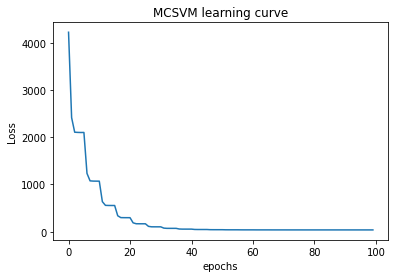

In [ ]:
plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.title('MCSVM learning curve')
plt.savefig('MCSVM.png')

In [ ]:
def eval(x, w):
    scores = w.dot(x.T)
    return np.argmax(scores, axis=0)

In [ ]:
def get_accuracy(x_test, y_test, w):
    pred = eval(x_test, w)
    return np.mean(pred == y_test)

In [ ]:
get_accuracy(x_test, y_test, W)

0.1528